## Backscatter Correction - Checkup Plot

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read
from scipy.signal import hilbert

In [2]:
from functions.load_backscatter_data import __load_backscatter_data
from functions.find_max_min import __find_max_min

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

## Configurations

In [4]:
config = {}

config['ring'] = "Z"

# test Z
config['tbeg'] = UTCDateTime("2024-08-02 00:00")
config['tend'] = UTCDateTime("2024-08-03 00:00")

# define nominal sagnac frequency of rings
config['ring_sagnac'] = {"U":303.05, "V":447.5, "W":447.5, "Z":553.5}
config['nominal_sagnac'] = config['ring_sagnac'][config['ring']]

## path to Sagnac data
# config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_data'] = data_path+"sagnac_frequency/data/backscatter/"


### Load Archive Files

In [5]:
bs = __load_backscatter_data(config['tbeg'], config['tend'], config['ring'], config['path_to_data'])

bs['time_sec'] = bs.time2 - bs.time1 + (bs.time1 - bs.time1.loc[0])

## Processing

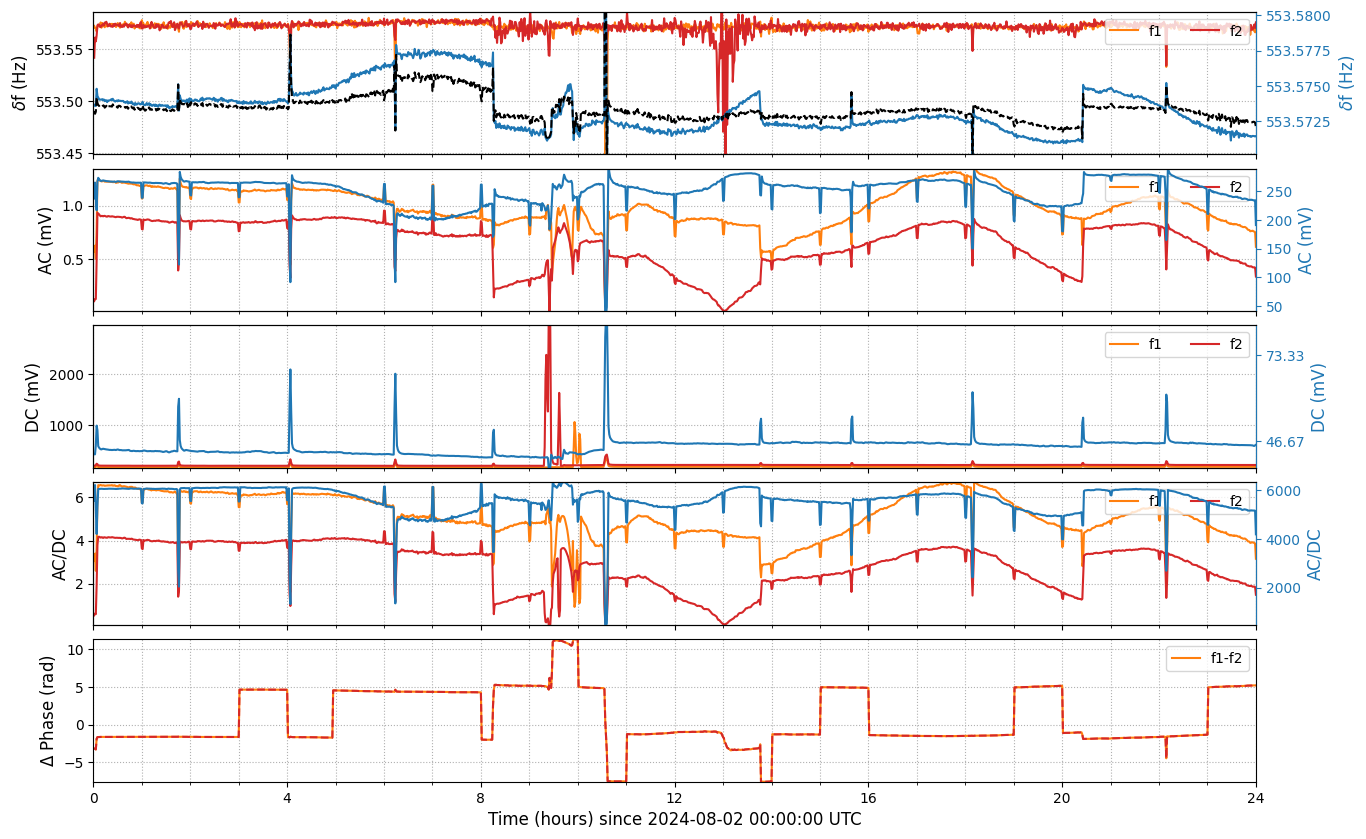

In [6]:
def __makeplot2(df):

    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

    Nrow, Ncol = 5, 1

    font = 12

    ms = 15

    tscale, tunit = 1/3600, "hours"

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    t_axis = bs.time_sec * tscale

    ax[0].plot(t_axis, df['f1_fs'], zorder=2, label="f1", color="tab:orange")
    ax[0].plot(t_axis, df['f2_fs'], zorder=2, label="f2", color="tab:red")
    ax[0].set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylim(__find_max_min([df['f1_fs'], df['f2_fs']], pp=99.9))

    ax00 = ax[0].twinx()
    ax00.plot(t_axis, df['fj_fs'], zorder=2, label="fj", color="tab:blue")
    ax00.plot(t_axis, df['w_s'], zorder=2, label="bs", ls="--", color="k")
    ax00.set_ylabel("$\delta$f (Hz)", fontsize=font)
    ax00.spines['right'].set_color('tab:blue')
    ax00.yaxis.label.set_color('tab:blue')
    ax00.tick_params(axis='y', colors='tab:blue')
    # ax00.set_yticks(np.linspace(ax00.get_yticks()[0], ax00.get_yticks()[-1], len(ax[0].get_yticks())))
    ax00.ticklabel_format(useOffset=False)
    ax00.set_ylim(__find_max_min([df['fj_fs']], pp=99.9))

    ax[1].plot(t_axis, df['f1_ac']*1e3, zorder=2, label="f1", color="tab:orange")
    ax[1].plot(t_axis, df['f2_ac']*1e3, zorder=2, label="f2", color="tab:red")
    ax[1].set_ylabel("AC (mV)", fontsize=font)
    ax[1].set_ylim(__find_max_min([df['f1_ac']*1e3, df['f2_ac']*1e3], pp=99.9))

    ax11 = ax[1].twinx()
    ax11.plot(t_axis, df['fj_ac']*1e3, zorder=2, label="fj")
    ax11.set_ylabel("AC (mV)", fontsize=font)
    ax11.spines['right'].set_color('tab:blue')
    ax11.yaxis.label.set_color('tab:blue')
    ax11.tick_params(axis='y', colors='tab:blue')
    # ax11.set_yticks(np.linspace(ax11.get_yticks()[0], ax11.get_yticks()[-1], len(ax[1].get_yticks())))
    ax11.set_ylim(__find_max_min([df['fj_ac']*1e3], pp=99.9))

    ax[2].plot(t_axis, df['f1_dc']*1e3, zorder=2, label="f1", color="tab:orange")
    ax[2].plot(t_axis, df['f2_dc']*1e3, zorder=2, label="f2", color="tab:red")
    ax[2].set_ylabel("DC (mV)", fontsize=font)
    ax[2].set_ylim(__find_max_min([df['f1_dc']*1e3, df['f2_dc']*1e3], pp=99.9))

    ax21 = ax[2].twinx()
    ax21.plot(t_axis, df['fj_dc']*1e3, zorder=2, label="fj")
    ax21.set_ylabel("DC (mV)", fontsize=font)
    ax21.spines['right'].set_color('tab:blue')
    ax21.yaxis.label.set_color('tab:blue')
    ax21.tick_params(axis='y', colors='tab:blue')
    ax21.set_yticks(np.linspace(ax21.get_yticks()[0], ax21.get_yticks()[-1], len(ax[2].get_yticks())))
    ax21.set_ylim(__find_max_min([df['fj_dc']*1e3], pp=99.9))

    ax[3].plot(t_axis, df['f1_ac']/df['f1_dc']*1e3, zorder=2, label="f1", color="tab:orange")
    ax[3].plot(t_axis, df['f2_ac']/df['f2_dc']*1e3, zorder=2, label="f2", color="tab:red")
    ax[3].set_ylabel("AC/DC", fontsize=font)
    # ax[3].set_ylim(0, 8e-3)
    ax[3].set_ylim(__find_max_min([df['f1_ac']/df['f1_dc']*1e3, df['f2_ac']/df['f2_dc']*1e3], pp=99.9))

    ax31 = ax[3].twinx()
    ax31.plot(t_axis, df['fj_ac']/df['fj_dc']*1e3, zorder=2, label="fj")
    ax31.set_ylabel("AC/DC", fontsize=font)
    ax31.spines['right'].set_color('tab:blue')
    ax31.yaxis.label.set_color('tab:blue')
    ax31.tick_params(axis='y', colors='tab:blue')
    ax31.set_yticks(np.linspace(ax31.get_yticks()[0], ax31.get_yticks()[-1], len(ax[3].get_yticks())))
    ax31.set_ylim(__find_max_min([df['fj_ac']/df['fj_dc']*1e3], pp=99.9))

    ax[4].plot(t_axis, df['f1_ph']-df['f2_ph'], color="tab:orange", zorder=2, label="f1-f2")
    ax[4].plot(t_axis, df['f1_ph']-df['f2_ph'], color="tab:red", zorder=2, ls="--")
    ax[4].set_ylabel("$\Delta$ Phase (rad)", fontsize=font)
    ax[4].set_ylim(__find_max_min([df['f1_ph']-df['f2_ph']], pp=99.9))

    for i in range(Nrow):
        ax[i].set_xlim(0, 24)
        ax[i].xaxis.set_major_locator(MultipleLocator(4))
        ax[i].xaxis.set_minor_locator(MultipleLocator(1))

    ax[4].set_xlabel(f"Time ({tunit}) since {config['tbeg'].date} {str(config['tbeg'].time)[:10]} UTC", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0, which="both")
        ax[_n].legend(loc=1, ncol=3)

    plt.show();
    return fig

fig = __makeplot2(bs);

# fig.savefig(config['path_to_figs']+f"SF_BS_{config['ring']}_{method}_values.png", format="png", dpi=150, bbox_inches='tight')
